In [1]:
from salishsea_tools import rivertools
import netCDF4 as NC
import numpy as np

In [7]:
reload(rivertools)

<module 'salishsea_tools.rivertools' from '/Users/sallen/Documents/MeoPar/Tools/SalishSeaTools/salishsea_tools/rivertools.py'>

In [2]:
#what type of file would you like to create?
#e.g. 'constant' - yearly average used for all months
#     'monthly' - monthly averages used for each month
rivertype = 'monthly'

In [8]:
#get river fluxes from netcdf file
if rivertype == 'constant':
    fluxfile = NC.Dataset('../../../nemo-forcing/rivers/Salish_allrivers_cnst.nc','r')
    #inialise the runoff and run_depth arrays
    runoff, run_depth, run_temp = rivertools.init_runoff_array()
if rivertype == 'monthly':
    fluxfile = NC.Dataset('../../../nemo-forcing/rivers/Salish_allrivers_monthly.nc','r')
    #inialise the runoff and run_depth arrays
    runoff, run_depth, run_temp = rivertools.init_runoff_array_monthly()

In [9]:
fluxfile1 = NC.Dataset('../../../nemo-forcing/rivers/Salish_allrivers_cnst.nc','r')
fluxfile2 = NC.Dataset('../../../nemo-forcing/rivers/Salish_allrivers_monthly.nc','r')
print fluxfile1.variables['skagit'][:]
print fluxfile2.variables['skagit'][:]

[ 937.34918213]
[ 1144.85083008  1003.11553955   875.92791748   924.40124512  1203.48510742
  1268.2265625    939.33544922   500.00836182   440.50671387   655.85516357
  1149.6385498   1150.28015137]


In [10]:
#list of watersheds we are including
names = ['skagit','fraser','evi_n','howe','bute','puget','jdf','evi_s','jervis','toba']

In [7]:
for name in range(0,len(names)):
    watershedname = names[name]
    Flux = fluxfile.variables[watershedname][:]
    if rivertype == 'constant':
        Flux = float(Flux)
    runoff_orig = np.copy(runoff)
    runoff, run_depth, run_temp = rivertools.put_watershed_into_runoff(rivertype,
                                            watershedname, Flux, runoff, run_depth, run_temp)
    if rivertype == 'constant':
        rivertools.check_sum(runoff_orig, runoff, Flux)
    if rivertype == 'monthly':
        rivertools.check_sum_monthly(runoff_orig, runoff, Flux)

skagit has 10 rivers
908.655847841 937.969
fraser has 10 rivers
3556.37459792 3539.81
evi_n has 21 rivers
255.798250913 638.889
howe has 2 rivers
587.571269457 571.458
bute has 3 rivers
606.331691748 547.856
puget has 43 rivers
481.252250068 503.333
jdf has 27 rivers
400.914077215 411.162
evi_s has 17 rivers
331.941328263 330.787
jervis has 17 rivers
307.539045044 296.967
toba has 1 rivers
285.070089693 269.932


In [8]:
#get dimensions for netcdf files
import netCDF4 as NC
fB = NC.Dataset('/ocean/sallen/allen/research/MEOPAR/nemo-forcing/grid/bathy_meter_SalishSea.nc','r')
lat = fB.variables['nav_lat']
lon = fB.variables['nav_lon']
D = fB.variables['Bathymetry'][:]
ymax, xmax = D.shape

In [9]:
if rivertype == 'constant':

    nemo = NC.Dataset('../../../NEMO-forcing/rivers/rivers_cnst.nc', 'w')
    nemo.description = 'Constant Yearly Average, All Rivers' 
    
    # dimensions
    nemo.createDimension('x', xmax)
    nemo.createDimension('y', ymax)
    nemo.createDimension('time_counter', None)
    
    # variables
    # latitude and longitude
    nav_lat = nemo.createVariable('nav_lat','float32',('y','x'),zlib=True)
    nav_lat = lat
    x = nemo.createVariable('nav_lon','float32',('y','x'),zlib=True)
    nav_lon = lon
    # time
    time_counter = nemo.createVariable('time_counter', 'float32', ('time_counter'),zlib=True)
    time_counter.units = 'non-dim'
    time_counter[0] = 1
    # runoff
    rorunoff = nemo.createVariable('rorunoff', 'float32', ('time_counter','y','x'), zlib=True)
    rorunoff._Fillvalue = 0.
    rorunoff._missing_value = 0.
    rorunoff._units = 'kg m-2 s-1'
    rorunoff[0,:] = runoff
    # depth
    rodepth = nemo.createVariable('rodepth','float32',('y','x'),zlib=True)
    rodepth._Fillvalue = -1.
    rodepth.missing_value = -1.
    rodepth.units = 'm'
    rodepth[:] = run_depth
    nemo.close()

In [10]:
print runoff.shape
print run_temp.shape

(12, 898, 398)
(12, 898, 398)


In [11]:
if rivertype == 'monthly':
    nemo = NC.Dataset('../../../NEMO-forcing/rivers/rivers_month.nc', 'w')
    nemo.description = 'Monthly Averages, All Rivers' 
    
    # dimensions
    nemo.createDimension('x', xmax)
    nemo.createDimension('y', ymax)
    nemo.createDimension('time_counter', None)
    
    # variables
    # latitude and longitude
    nav_lat = nemo.createVariable('nav_lat','float32',('y','x'),zlib=True)
    nav_lat = lat
    x = nemo.createVariable('nav_lon','float32',('y','x'),zlib=True)
    nav_lon = lon
    # time
    time_counter = nemo.createVariable('time_counter', 'float32', ('time_counter'),zlib=True)
    time_counter.units = 'non-dim'
    time_counter[0:12] = range(1,13)
    # runoff
    rorunoff = nemo.createVariable('rorunoff', 'float32', ('time_counter','y','x'), zlib=True)
    rorunoff._Fillvalue = 0.
    rorunoff._missing_value = 0.
    rorunoff._units = 'kg m-2 s-1'
    rorunoff[0:12,:] = runoff
    # depth
    rodepth = nemo.createVariable('rodepth','float32',('y','x'),zlib=True)
    rodepth._Fillvalue = -1.
    rodepth.missing_value = -1.
    rodepth.units = 'm'
    rodepth[:] = run_depth[0,:,:]
    # temperature
    rotemper = nemo.createVariable('rotemper','float32',('time_counter','y','x'),zlib=True)
    rotemper._Fillvalue = -99.
    rotemper.missing_value = -99.
    rotemper.units = 'deg C'
    rotemper[0:12,:] = run_temp
    nemo.close()

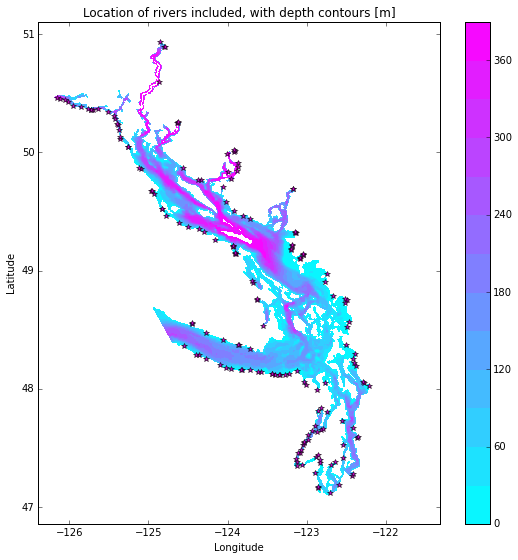

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

test = NC.Dataset('../../../NEMO-forcing/rivers/rivers_month.nc','r')
plotting = test.variables['rorunoff'][0,:,:]

plt.figure(figsize=(9,9))
plt.contourf(lon,lat,D,np.arange(0,420,30),cmap='cool')
for i in range(0,898):
    for j in range(0,398):
        if plotting[i,j] > 0:
            plt.plot(lon[i,j],lat[i,j],'m*')
plt.colorbar()
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Location of rivers included, with depth contours [m]')
plt.savefig('river_locations.pdf')


(12, 898, 398)


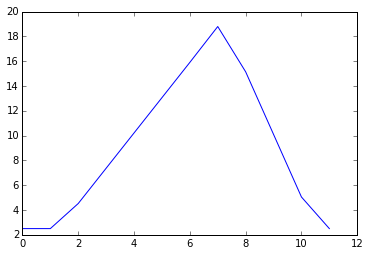

In [14]:
temp = test.variables['rotemper'][:]
print temp.shape
plt.plot(temp[:,351,345])